The TFrecord is a simple format for storing a sequence of binary data. `Protocol buffers` are a library for efficient serialization of structured data. Protocol messages are generally defined as `.proto` files.

In [0]:
!pip install -q tf-nightly

In [130]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200112
Eager Mode: True
GPU is available


# `tf.Example`

Overall, a `tf.Example` message is a type of mapping `{"string": tf.train.Feature}`. The `tf.example` is a way of implementing `protocol buffers`. This tutorial guides you on how to create, parse and use the `tf.Example` message. Second, serialize, write and read the `tf.Example` message to or from the `tfrecord` files.

## Data types for `tf.Example`

The `tf.train.Feature` message type can accept the following three types.
* `tf.train.BytesList`: `string`, `byte`
* `tf.train.FloatList`: `float`, `Double`
* `tf.train.Int64List`: `bool`, `enum`, `int`(32, 64), `uint`(32, 64)

In order to convert a standard datatype in Tensorflow to a `tf.Example`-compatible `tf.train.Feature`, you can use the following scripts to transform a scalar to a `tf.train.Feature` format.

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('UTF-8')))
print(_float_feature(np.exp(1)))
print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



All returns above are `Protocol Buffers` formats. These messages can be serialized to a binary string using the `.SerializeToString()` method.

In [5]:
print(_bytes_feature(u"test utf-8 string".encode("UTF-8")).SerializeToString())
print(_float_feature(np.exp(1)).SerializeToString())

b'\n\x13\n\x11test utf-8 string'
b'\x12\x06\n\x04T\xf8-@'


## Creating a `tf.Example` Message

Here you are going to generate a `tf.Example` message on the example data.

In [0]:
# the number of observations in the dataset
n_observations = int(1e4)

# boolean features
feature0 = np.random.choice([False, True], n_observations)

# integer features
feature1 = np.random.randint(low=0, high=5, size=n_observations)

# string features
strings = np.array([b'apple', b'banana', b'orange', b'raspberry', b'strawberry'])
feature2 = strings[feature1]

# float features
feature3 = np.random.randn(n_observations)

A simple wrapper function to generate a `tf.Example` message.

In [0]:
def serialize_example(feature0, feature1, feature2, feature3):
  # create a dictionary mapping the feature name to tf.Example-compatible datatype
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3)
  }

  # create a Feature message using tf.train.Example
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

You can easily pass a few scalars to the function to generate a `tf.Example` serialized binary string.

In [8]:
serialized_example = serialize_example(False, 9, b'banana', 0.99876)
serialized_example

b'\nT\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xbc\xae\x7f?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\t\n\x16\n\x08feature2\x12\n\n\x08\n\x06banana'

You can also decode the binary string back to messages via the `tf.train.Example.FromString()` API.

In [9]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "banana"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9987599849700928
      }
    }
  }
}

# TFRecords Format Details

The `tf.Example` here is an example to manipulate the `TFRecord` files. But it is not the only way to do that. A `TFRecord` file contains a sequence of records so that the file can be read sequentially.

The following is a simple example of taking image data.

In [0]:
def create_img_example(imgInByte, labelInByte):
  feature = {
      'image': _bytes_feature(imgInByte),
      'label': _bytes_feature(labelInByte)
  }
  tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
  return tf_example

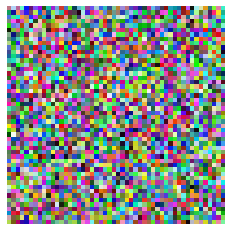

In [11]:
_img = np.random.randint(0, 256, size=50*50*3)
img = _img.reshape((50, 50, 3))

plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
label = 9
img_enc = tf.image.encode_jpeg(img)
label_enc = str(label).encode("UTF-8")

create_img_example(img_enc, label_enc)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\0002\0002\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWX

# TFRecord files using `tf.data`

## Writing a TFRecord file

The easier way to get the data into a dataset is to use the `from_tensor_slices` method.

In [13]:
tf.data.Dataset.from_tensor_slices(feature0)

<TensorSliceDataset shapes: (), types: tf.bool>

In [14]:
feature_dataset = tf.data.Dataset.from_tensor_slices(
    (feature0, feature1, feature2, feature3))
feature_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [15]:
for f0, f1, f2, f3 in feature_dataset.take(1):
  print(f0, f1, f2, f3)

tf.Tensor(False, shape=(), dtype=bool) tf.Tensor(0, shape=(), dtype=int64) tf.Tensor(b'apple', shape=(), dtype=string) tf.Tensor(1.7042747415625106, shape=(), dtype=float64)


Use `tf.data.Dataset.map` to apply a function to each element of a dataset. The map function must operate in the Tensorflow graph and it must operate on and return `tf.Tensor`. You can wrap a non-tensor function with a `py_function` method to make it compatible.

In [0]:
def tf_serialize_example(f0, f1, f2, f3):
  tf_string = tf.py_function(
      serialize_example,
      inp=(f0, f1, f2, f3),
      Tout=tf.string
  )
  return tf.reshape(tf_string, ()) # the result is a scalar

In [17]:
tf_serialize_example(f0, f1, f2, f3)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x15\n\x08feature2\x12\t\n\x07\n\x05apple\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xad%\xda?'>

Apply this function to a dataset.

In [104]:
serialized_features_dataset = feature_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

Next, you can define a generator to sequentially transform data and write out to a TFrecord file.

In [0]:
def generator():
  for features in feature_dataset:
    yield serialize_example(*features)

In [20]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=()
)
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

In [0]:
writer = tf.data.experimental.TFRecordWriter("test.tfrecord")
writer.write(serialized_features_dataset)

## Reading a TFRecord File

You can easily read the TFrecord files via the `tf.data.TFRecordDataset` method.

In [22]:
filenames = ["test.tfrecord", "test2.tfrecord"]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [23]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x15\n\x08feature2\x12\t\n\x07\n\x05apple\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xad%\xda?'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nT\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x16\n\x08feature2\x12\n\n\x08\n\x06banana\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xd2\xd5h>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nT\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x16\n\x08feature2\x12\n\n\x08\n\x06banana\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xb9\xb4X\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nW\n\x19\n\x08feature2\x12\r\n\x0b\n\traspberry\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x8eU\xb9>\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\

After you created a `TFrecord` file, you can parse it and deserialize single data using the following script. Note here the `feature_desc` is necessary because datasets use graph execution, it requires definitions of shapes and signatures of each feature.

In [0]:
feature_desc = {
  'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
  'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
  'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
  'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0)
}

def _parse_function(example_proto):
  # parse the input `tf.Example` proto using the feature_desc defined above
  return tf.io.parse_single_example(example_proto, features=feature_desc)

You can parse a batch of dataset once. You can use `tf.io.FixedLenSequenceFeature` or `tf.io.FixedLenFeature` to load a batch of dataset via the `tf.io.parse_example` method. However, two methods result in different results. The `tf.io.FixedLenSequenceFature` makes a new batch axis at 0 to become `[Batch_size, 1`] and on the other hand, the `tf.io.FixedLenFeature` processes the dataset as the shape of `[Batch_size,]`.

In [0]:
batch_feature_desc = {
  'feature0': tf.io.FixedLenSequenceFeature([], tf.int64, default_value=0, allow_missing=True),
  'feature1': tf.io.FixedLenSequenceFeature([], tf.int64, default_value=0, allow_missing=True),
  'feature2': tf.io.FixedLenSequenceFeature([], tf.string, default_value='', allow_missing=True),
  'feature3': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0, allow_missing=True)
}

# batch_feature_desc = {
#   'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
#   'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
#   'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
#   'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0)
# }

def _parse_batch_function(example_proto):
  return tf.io.parse_example(example_proto, features=batch_feature_desc)

Take 10 examples one by one.

In [26]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [27]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'apple'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=1.7042748>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'banana'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.22737816>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'banana'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.8465076>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'raspberry'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.36198086>}
{'f

You can add a method `.batch(BATCH_SIZE)` to get a batch of datasets.

In [87]:
parsed_batch_dataset = raw_dataset.batch(5).map(_parse_batch_function)
parsed_batch_dataset

<MapDataset shapes: {feature0: (None, None), feature1: (None, None), feature2: (None, None), feature3: (None, None)}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [89]:
for parsed_batch_record in parsed_batch_dataset.take(1):
  print(repr(parsed_batch_record))

{'feature0': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [1],
       [0],
       [0]])>, 'feature1': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [1],
       [3],
       [3]])>, 'feature2': <tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b'apple'],
       [b'banana'],
       [b'banana'],
       [b'raspberry'],
       [b'raspberry']], dtype=object)>, 'feature3': <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.7042748 ],
       [ 0.22737816],
       [-0.8465076 ],
       [ 0.36198086],
       [-0.67072153]], dtype=float32)>}


# TFRecord Files in Python

The `tf.io` APIs are also providing lots of pure Python functions to write and read a `tfrecord` file.

## Writing a TFRecord File

In [0]:
with tf.io.TFRecordWriter("test_io.tfrecord") as fout:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    fout.write(example)

In [91]:
!du -sh "test_io.tfrecord"

1008K	test_io.tfrecord


## Reading a TFRecord File

In [92]:
filenames = ["test_io.tfrecord"]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [108]:
for raw_record in raw_dataset.take(1):
  # way.1
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

  # way.2
  print(tf.train.Example.FromString(raw_record.numpy()))

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "apple"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 1.7042747735977173
      }
    }
  }
}

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "apple"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 1.7042747735977173
      }
    }
  }
}



# Example: Reading and Writing Image Datasets

## Fetching the Image Files

A simple image dataset is listed below. An image is saved as the format, `[class_label, file_name, file_url]`.

In [0]:
img_url = [
  "0,134409839_71069a95d1_m.jpg,https://raw.githubusercontent.com/jiankaiwang/TF_ObjectDetection_Flow/master/raw/origindata/daisy/134409839_71069a95d1_m.jpg",
  "1,133692329_c1150ed811_n.jpg,https://raw.githubusercontent.com/jiankaiwang/TF_ObjectDetection_Flow/master/raw/origindata/tulips/133692329_c1150ed811_n.jpg"
]

In [0]:
spilt_data = img_url[0].split(',')
img_path = tf.keras.utils.get_file(spilt_data[1], spilt_data[2])

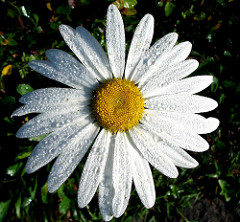

In [135]:
display.display(display.Image(filename=img_path))

## Writing the TFRecord File

In [0]:
# open an image in the binary format
image_string = open(img_path, 'rb').read()

# get the label
image_label = int(spilt_data[0])

In [0]:
def image_example(img_str, label):
  image_shape = tf.image.decode_jpeg(img_str).shape

  feature = {
    'height': _int64_feature(image_shape[0]), 
    'width': _int64_feature(image_shape[1]),
    'depth': _int64_feature(image_shape[2]),
    'label': _int64_feature(label),
    'image_raw': _bytes_feature(img_str)
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

A simple example.

In [141]:
image_example(image_string, image_label)

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 222
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\003\002\002\003\002\002\003\003\003\003\004\003\003\004\005\010\005\005\004\004\005\n\007\007\006\010\014\n\014\014\013\n\013\013\r\016\022\020\r\016\021\016\013\013\020\026\020\021\023\024\025\025\025\014\017\027\030\026\024\030\022\024\025\024\377\333\000C\001\003\004\004\005\004\005\t\005\005\t\024\r\013\r\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\024\377\300\000\021\010\000\336\000\360\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001

An example is shown for sequential loading image datasets.

In [0]:
for line in img_url:
  spilt_data = line.split(',')
  img_path = tf.keras.utils.get_file(spilt_data[1], spilt_data[2])

  image_str = open(img_path, "rb").read()
  image_label = int(spilt_data[0])

  print(image_example(image_str, image_label))

In [0]:
img_record_path = "image_example.tfrecords"

with tf.io.TFRecordWriter(img_record_path) as fout:
  for line in img_url:
    spilt_data = line.split(',')
    img_path = tf.keras.utils.get_file(spilt_data[1], spilt_data[2])

    image_str = open(img_path, "rb").read()
    image_label = int(spilt_data[0])

    # serialize a `tf.train.Example` message and write it to a TFRecord file
    serialized = image_example(image_str, image_label).SerializeToString()

    fout.write(serialized)

In [151]:
!du -sh {img_record_path}

52K	image_example.tfrecords


## Reading the TFRecord File

In [0]:
tfrecord_list = [img_record_path]
raw_image_dataset = tf.data.TFRecordDataset(tfrecord_list)

In [0]:
feature_desc = {
  'height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
  'width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
  'depth': tf.io.FixedLenFeature([], tf.int64, default_value=3),
  'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
  'image_raw': tf.io.FixedLenFeature([], tf.string, default_value='')
}

def _parse_single_data(protos):
  return tf.io.parse_single_example(protos, features=feature_desc)

In [0]:
raw_image_dataset = raw_image_dataset.map(_parse_single_data)

H:222, W:240, D:3, Label:0


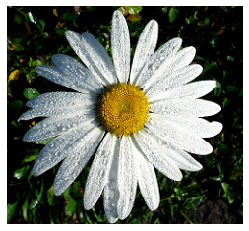

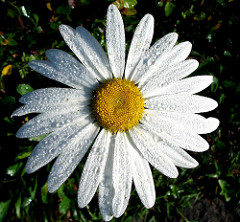

H:240, W:320, D:3, Label:1


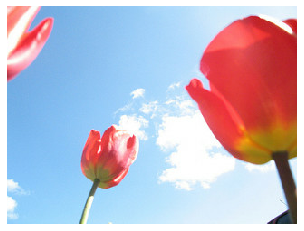

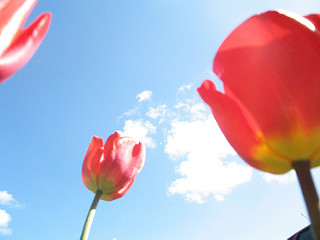

In [179]:
for img_obj in raw_image_dataset.take(2):
  height, width, depth = img_obj["height"], img_obj["width"], img_obj["depth"]
  label = img_obj["label"]
  print("H:{}, W:{}, D:{}, Label:{}".format(height, width, depth, label))

  img_content = tf.image.decode_jpeg(img_obj["image_raw"])
  plt.imshow(img_content)
  plt.axis("off")
  plt.show()

  img_content_2 = img_obj["image_raw"]
  display.display(display.Image(data=img_content_2.numpy()))